<a href="https://colab.research.google.com/github/Sumanth-Mahabaleshwar-Bhat/SpecialTopicsML-Winter2022/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

In [ ]:
# Importing Fake and True News dataset
fake = pd.read_csv("Documents/Fake.csv")
true = pd.read_csv("Documents/True.csv")

In [ ]:
# Adding flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [ ]:
# Concatenating dataframes
data = pd.concat([fake, true]).reset_index(drop = True)

In [ ]:
# Shuffling the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
# Check the data
data.head()

,title,text,subject,date,target
0,Trump’s Attorney General Pick Thinks Kids Wit...,"Yes, you read the title correctly. Trump s pic...",News,"November 29, 2016",fake
1,Poland to allocate additional $55 bllion on de...,WARSAW (Reuters) - Poland will allocate an add...,worldnews,"August 23, 2017",true
2,U.S. judge aims to quickly decide lawsuits ove...,SAN FRANCISCO (Reuters) - A U.S. judge on Thur...,politicsNews,"September 21, 2017",true
3,OUTRAGEOUS! CNN Uses Unauthorized Video Taken ...,This video from CNN has been blasted to Daily ...,politics,"Mar 5, 2017",fake
4,SICK OF HOLLYWOOD LIBERALS and PERVERTS? Here’...,"Actor Kevin Sorbo and his wife, actress Sam So...",left-news,"Oct 26, 2017",fake


In [ ]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,date,target
0,"Yes, you read the title correctly. Trump s pic...",News,"November 29, 2016",fake
1,WARSAW (Reuters) - Poland will allocate an add...,worldnews,"August 23, 2017",true
2,SAN FRANCISCO (Reuters) - A U.S. judge on Thur...,politicsNews,"September 21, 2017",true
3,This video from CNN has been blasted to Daily ...,politics,"Mar 5, 2017",fake
4,"Actor Kevin Sorbo and his wife, actress Sam So...",left-news,"Oct 26, 2017",fake


In [ ]:
# Converting to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,date,target
0,"yes, you read the title correctly. trump s pic...",News,"November 29, 2016",fake
1,warsaw (reuters) - poland will allocate an add...,worldnews,"August 23, 2017",true
2,san francisco (reuters) - a u.s. judge on thur...,politicsNews,"September 21, 2017",true
3,this video from cnn has been blasted to daily ...,politics,"Mar 5, 2017",fake
4,"actor kevin sorbo and his wife, actress sam so...",left-news,"Oct 26, 2017",fake


In [ ]:
# Removing punctuation
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
data['text'] = data['text'].apply(punctuation_removal)

In [ ]:
# Checking the data after removing punctuation
data.head()

,text,subject,date,target
0,yes you read the title correctly trump s pick ...,News,"November 29, 2016",fake
1,warsaw reuters poland will allocate an additi...,worldnews,"August 23, 2017",true
2,san francisco reuters a us judge on thursday ...,politicsNews,"September 21, 2017",true
3,this video from cnn has been blasted to daily ...,politics,"Mar 5, 2017",fake
4,actor kevin sorbo and his wife actress sam sor...,left-news,"Oct 26, 2017",fake


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


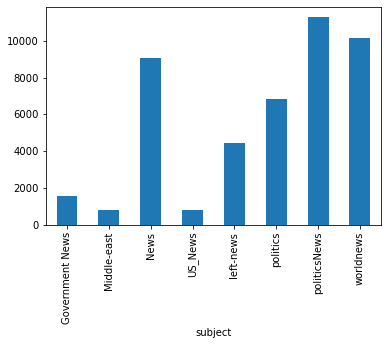

In [ ]:
# Listing number of articles per subject
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [ ]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

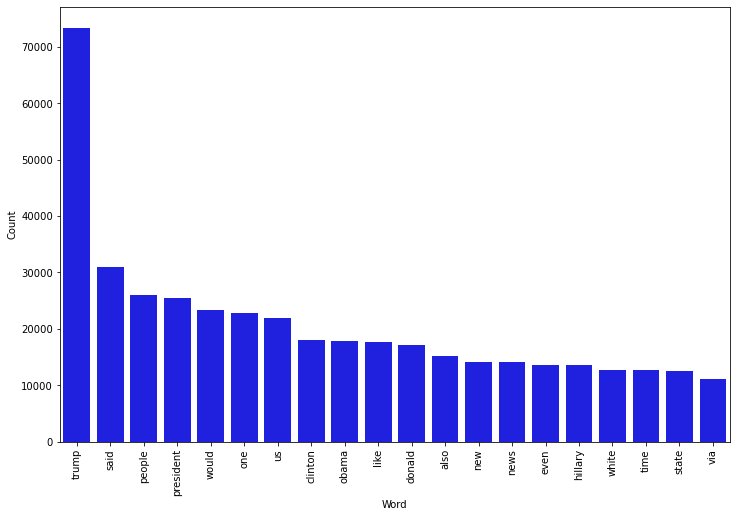

In [ ]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

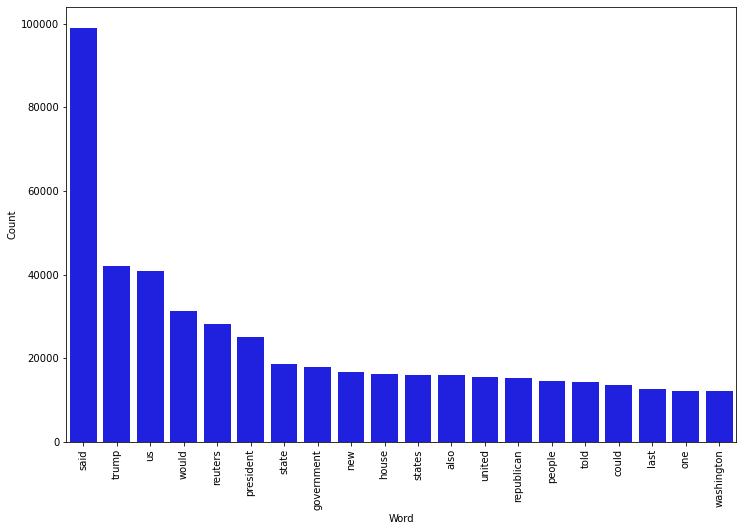

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

In [ ]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=1124)

In [ ]:
# plotting Confusion matrix function
def confusion_matrix(y_test, prediction):
    cm = metrics.confusion_matrix(y_test, prediction)
    plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
def evaluation_metrics(y_test, prediction, classification_type):
    accuracy = round(accuracy_score(y_test, prediction)*100,2)
    precision = round(precision_score(y_test, prediction, pos_label='true')*100,2)
    recall = round(recall_score(y_test, prediction, pos_label='true')*100,2)
    f1 = round(f1_score(y_test, prediction, pos_label='true')*100,2)
    print("Accuracy of " + classification_type + " is : {}%".format(accuracy))
    print("Precision of " + classification_type + " is : {}%".format(precision))
    print("Recall of " + classification_type + " is : {}%".format(recall))
    print("F1 Score of " + classification_type + " is : {}%".format(f1))

In [ ]:
# Logistic Regression
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
def logistic_regression():
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
    # Fitting the model
    model = pipe.fit(X_train, y_train)
    # Accuracy
    prediction = model.predict(X_test)
    evaluation_metrics(y_test, prediction, "Logistic Regression")
    confusion_matrix(y_test, prediction)

In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
def decision_tree_classifier():
    # Vectorizing and applying TF-IDF
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
    # Fitting the model
    model = pipe.fit(X_train, y_train)
    # Accuracy
    prediction = model.predict(X_test)
    evaluation_metrics(y_test, prediction, "Decision Tree Classifier")
    confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random forest classifier
def random_forest_classifier():
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
    model = pipe.fit(X_train, y_train)
    prediction = model.predict(X_test)
    evaluation_metrics(y_test, prediction, "Random Forest Classifier")
    confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#Naive Bayes Classifier
def naive_bayes_classifier():
    pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])
    model = pipe.fit(X_train, y_train)
    prediction = model.predict(X_test)
    evaluation_metrics(y_test, prediction, "Naive Bayes Classifier")
    confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.svm import LinearSVC
# SVM Classifier
def svm_classifier():
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])
    model_SVC = pipe.fit(X_train, y_train)
    prediction = model_SVC.predict(X_test)
    evaluation_metrics(y_test, prediction, "SVM Classifier")
    confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# KNN Classifier
def knn_classifier():
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'))])
    model_KNN = pipe.fit(X_train, y_train)
    prediction = model_KNN.predict(X_test)
    evaluation_metrics(y_test, prediction, "KNN Classifier")
    confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# AdaBoost Classifier
def ada_boost_classifier():
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', AdaBoostClassifier(learning_rate = 0.01,n_estimators = 10,))])
    model_AB = pipe.fit(X_train, y_train)
    prediction = model_AB.predict(X_test)
    evaluation_metrics(y_test, prediction, "AdaBoost Classifier")
    confusion_matrix(y_test, prediction)

Accuracy of Logistic Regression is : 99.03%
Precision of Logistic Regression is : 98.84%
Recall of Logistic Regression is : 99.14%
F1 Score of Logistic Regression is : 98.99%
Confusion matrix, without normalization


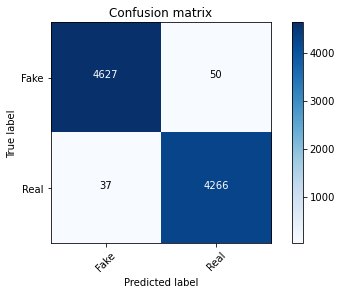

In [ ]:
# Calling all the classifier functions
logistic_regression()

Accuracy of Decision Tree Classifier is : 99.69%
Precision of Decision Tree Classifier is : 99.7%
Recall of Decision Tree Classifier is : 99.65%
F1 Score of Decision Tree Classifier is : 99.67%
Confusion matrix, without normalization


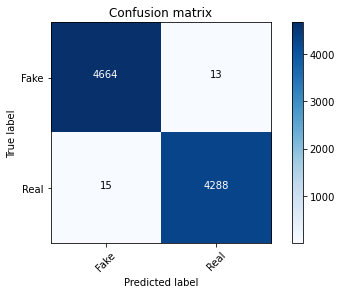

In [ ]:
decision_tree_classifier()

Accuracy of Random Forest Classifier is : 99.25%
Precision of Random Forest Classifier is : 98.94%
Recall of Random Forest Classifier is : 99.51%
F1 Score of Random Forest Classifier is : 99.22%
Confusion matrix, without normalization


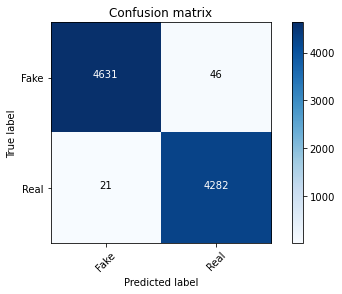

In [ ]:
random_forest_classifier()

Accuracy of Naive Bayes Classifier is : 95.58%
Precision of Naive Bayes Classifier is : 94.11%
Recall of Naive Bayes Classifier is : 96.84%
F1 Score of Naive Bayes Classifier is : 95.45%
Confusion matrix, without normalization


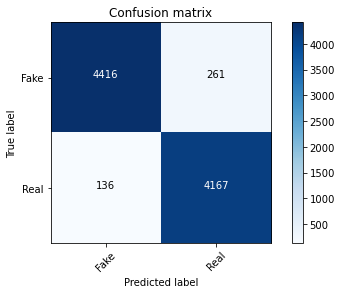

In [ ]:
naive_bayes_classifier()

Accuracy of SVM Classifier is : 99.62%
Precision of SVM Classifier is : 99.56%
Recall of SVM Classifier is : 99.65%
F1 Score of SVM Classifier is : 99.61%
Confusion matrix, without normalization


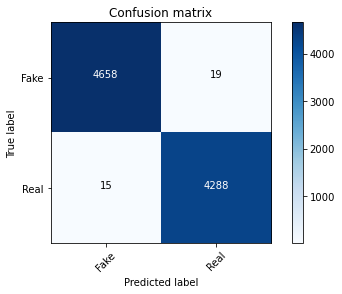

In [ ]:
svm_classifier()

In [ ]:
knn_classifier()

In [ ]:
ada_boost_classifier()